In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# from tf.keras.models import Sequential # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

# ModelCheckpoint

In [3]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series
from tslearn.utils import to_time_series_dataset
from tslearn.datasets import UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans

In [4]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [5]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [6]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')

In [7]:
weather_time = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/인천_시간별_기상자료.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_time['지점']

In [8]:
for k in range(1,len(train.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    train_median=train.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=train.loc[ train.iloc[:,k].isnull()==False ][ train.columns[k] ].index

    df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if train.iloc[i,k]>=train_median: #현재 index에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            train.iloc[ i : i+j+1 , k] = train.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중
250 번째 실행중
300 번째 실행중
350 번째 실행중
400 번째 실행중
450 번째 실행중
500 번째 실행중
550 번째 실행중
600 번째 실행중
650 번째 실행중
700 번째 실행중
750 번째 실행중
800 번째 실행중
850 번째 실행중
900 번째 실행중
950 번째 실행중
1000 번째 실행중
1050 번째 실행중
1100 번째 실행중
1150 번째 실행중
1200 번째 실행중
1250 번째 실행중
1300 번째 실행중


In [9]:
for k in range(1,len(test.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    test_median=test.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=test.loc[ test.iloc[:,k].isnull()==False ][ test.columns[k] ].index

    df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if test.iloc[i,k]>=test_median: #현재 indetestx에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            test.iloc[ i : i+j+1 , k] = test.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중


In [10]:
train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time',inplace=True)

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

In [11]:
train_sample = train['2018-02-15':]
train_sample = train_sample.interpolate(method='values')

test_sample = test['2018-02-15':]
test_sample = test_sample.interpolate(method='values')

In [12]:
# 결측값 가진 행 제거 - 데이터가 아예 없는 경우
# train_sample.loc[:,train_sample.isnull().sum() >= 1].columns

In [13]:
# #결측값 가진 행 제거 - 데이터가 아예 없는 경우
# test_sample.loc[:,test_sample.isnull().sum() >= 1].columns

In [14]:
train_sample.drop(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'], axis=1, inplace=True)

test_sample.drop(['X26', 'X16', 'X7', 'X18', 'X41', 'X55', 'X5', 'X43', 'X59', 'X10',
       'X62', 'X61', 'X32', 'X31', 'X30', 'X51', 'X35', 'X44', 'X37', 'X42',
       'X50', 'X47', 'X20'],axis=1,inplace=True)

In [15]:
# train_sample = pd.read_csv('train_sample',index_col='Time',parse_dates=True)
# test_sample = pd.read_csv('test_sample',index_col='Time',parse_dates=True)

> 입력신호 추가

In [16]:
train_sample = train_sample.resample('D').sum()
test_sample = test_sample.resample('D').sum()

In [17]:
train_sample['temp'] = weather_time['기온(°C)']['2018-02-15':].resample('D').mean() 
train_sample['humidity'] = weather_time['습도(%)']['2018-02-15':].resample('D').mean() 
train_sample[['temp','humidity']] = train_sample[['temp','humidity']].interpolate(method='values')  # 온도 결측값을 시간에 따른 보간법으로 채움
train_sample['DayOfWeek'] = train_sample.index.dayofweek


test_sample['temp'] = weather_time['기온(°C)']['2018-02-15':].resample('D').mean()
test_sample['humidity'] = weather_time['습도(%)']['2018-02-15':].resample('D').mean() 
test_sample[['temp','humidity']] = test_sample[['temp','humidity']].interpolate(method='values')  # 온도 결측값을 시간에 따른 보간법으로 채움
test_sample['DayOfWeek'] = train_sample.index.dayofweek

In [18]:
# 공휴일 목록
holiday_list=['2018-02-15','2018-02-16','2018-02-17','2018-03-01','2018-05-05','2018-05-07','2018-05-22','2018-06-06','2018-06-13']

# 토요일/일요일 

a= train_sample['2018-02-17':].index
b= train_sample['2018-02-19':].resample('B').sum().index

list_a = []
for i in range(len(a.values)):
    list_a.append(a.values[i])
list_b = []
for i in range(len(b.values)):
    list_b.append(b.values[i])

list_tmp = []
for i in list_a:
    if i not in list_b:
        list_tmp.append(i)
      
    
# list_tmp # 토요일/일요일
saturday_sunday = np.array(list_tmp) # 툐요일/일요일 index => ndarray

# # 주말목록 / 주말색인 구한 뒤 합침
for i in range(len(saturday_sunday)):
    holiday_list.append(str(saturday_sunday[i])[:10])

> Input 형식

>  (전체세대시간, 24시간, 2 )

In [19]:
from sklearn.preprocessing import MinMaxScaler

sc_train = MinMaxScaler() # trainSet scaler
sc_test = MinMaxScaler() # testSet scaler
sc_temp = MinMaxScaler() # temp scaler
sc_humidity = MinMaxScaler()
sc_DayOfWeek = MinMaxScaler()

train_sample_sc = sc_train.fit_transform(train_sample.iloc[:,:-3])
test_sample_sc = sc_test.fit_transform(test_sample.iloc[:,:-3])
temp_sc = sc_temp.fit_transform(train_sample[['temp']])
humidity_sc = sc_humidity.fit_transform(train_sample[['humidity']])
DayOfWeek_sc = sc_DayOfWeek.fit_transform(train_sample[['DayOfWeek']])


train_sample_sc = np.concatenate((train_sample_sc, temp_sc), axis=1)
train_sample_sc = np.concatenate((train_sample_sc, humidity_sc), axis=1)
train_sample_sc = np.concatenate((train_sample_sc, DayOfWeek_sc), axis=1)



test_sample_sc = np.concatenate((test_sample_sc, temp_sc), axis=1)
test_sample_sc = np.concatenate((test_sample_sc, humidity_sc), axis=1)
test_sample_sc = np.concatenate((test_sample_sc, DayOfWeek_sc), axis=1)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [20]:
train_sample = pd.DataFrame(train_sample_sc, columns=train_sample.columns,index=train_sample.index)
test_sample = pd.DataFrame(test_sample_sc, columns=test_sample.columns,index=test_sample.index)

In [21]:
train_sample['holiDay'] = 0 # holiday feature 추가 / 우선 0으로 

for i in range(len(train_sample)):
    if str(train_sample.index[i])[:10] in holiday_list :
        train_sample['holiDay'].iloc[i] = 1 # 쉬는날이면 1
    else:
        train_sample['holiDay'].iloc[i] = 0 # 쉬는날 아니면 0
        
# 같은방법으로 test_sample도

test_sample['holiDay'] = 0 # holiday feature 추가 / 우선 0으로 

for i in range(len(test_sample)):
    if str(test_sample.index[i])[:10] in holiday_list :
        test_sample['holiDay'].iloc[i] = 1 # 쉬는날이면 1
    else:
        test_sample['holiDay'].iloc[i] = 0 # 쉬는날 아니면 0

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
# train_sample = pd.read_csv('train_sample_forecast_일별',index_col='Time',parse_dates=True) # scaling 된거
# test_sample = pd.read_csv('test_sample_forecast_일별',index_col='Time',parse_dates=True)

In [23]:
shift_step = 10

In [24]:
tmp_list = [] 
for i in train_sample.columns[:-4]:
    tmp_list.append(train_sample[[i,'temp','DayOfWeek','holiDay','humidity']]["2018-02-21":].values[:-shift_step].reshape(12,10,5)) 

to_formatted_x = np.array(tmp_list)

In [25]:
res_x = to_formatted_x.reshape(to_formatted_x.shape[0]*to_formatted_x.shape[1],10,5)

res_x.shape

(15024, 10, 5)

In [26]:
for_shifting_y = train_sample.shift(-10)
# for_shifting_y=for_shifting_y.dropna()

tmp_shift_list = []
for i in train_sample.columns[:-4]:
    tmp_shift_list.append(for_shifting_y[i]['2018-02-21':].values[:-shift_step].reshape(12,10,1))

to_formatted_y = np.array(tmp_shift_list)

In [27]:
res_y = to_formatted_y.reshape(to_formatted_x.shape[0]*to_formatted_x.shape[1],10,1)

res_y.shape

(15024, 10, 1)

In [28]:
############################################### TEST DATA #############################################################

In [29]:
tmp_test_list = [] 
for i in test_sample.columns[:-4]:
    tmp_test_list.append(test_sample[[i,'temp','DayOfWeek','holiDay','humidity']]['2018-02-21':].values[:-shift_step].reshape(12,10,5)) 

to_formatted_test_x = np.array(tmp_test_list)

In [30]:
res_test_x = to_formatted_test_x.reshape(to_formatted_test_x.shape[0]*to_formatted_test_x.shape[1],10,5)

res_test_x.shape

(2124, 10, 5)

In [31]:
for_shifting_y = test_sample.shift(-10)

tmp_test_shift_list = []
for i in test_sample.columns[:-4]:
    tmp_test_shift_list.append(for_shifting_y[i]['2018-02-21':].values[:-shift_step].reshape(12,10,1))

to_formatted_test_y = np.array(tmp_test_shift_list)

In [32]:
# to_formatted_test_y.shape

In [33]:
res_test_y = to_formatted_test_y.reshape(to_formatted_test_x.shape[0]*to_formatted_test_x.shape[1],10,1)

res_test_y.shape

(2124, 10, 1)

In [34]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
from keras.layers import TimeDistributed
K.clear_session()

model = Sequential() # Sequeatial Model 
model.add(LSTM(128, input_shape=(10, 5),return_sequences=True)) # (timestep, feature)
model.add(TimeDistributed(Dense(1, activation="linear")))
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 128)           68608     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 1)             129       
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 모델 학습
early_stop = EarlyStopping(monitor='loss',patience=4, verbose=1)

history = model.fit(res_x,res_y,epochs=50,batch_size=512,verbose=1,validation_split=0.2,shuffle=True,callbacks=[early_stop])


Train on 12019 samples, validate on 3005 samples
Epoch 1/50
12019/12019 [==============================] - 2s 208us/step - loss: 0.1080 - val_loss: 0.0659
Epoch 2/50
12019/12019 [==============================] - 2s 173us/step - loss: 0.0547 - val_loss: 0.0464
Epoch 3/50
12019/12019 [==============================] - 2s 171us/step - loss: 0.0432 - val_loss: 0.0392
Epoch 4/50
12019/12019 [==============================] - 2s 169us/step - loss: 0.0372 - val_loss: 0.0343
Epoch 5/50
12019/12019 [==============================] - 2s 175us/step - loss: 0.0335 - val_loss: 0.0312
Epoch 6/50
12019/12019 [==============================] - 2s 171us/step - loss: 0.0313 - val_loss: 0.0296
Epoch 7/50
12019/12019 [==============================] - 2s 171us/step - loss: 0.0299 - val_loss: 0.0283
Epoch 8/50
12019/12019 [==============================] - 2s 172us/step - loss: 0.0289 - val_loss: 0.0274
Epoch 9/50
12019/12019 [==============================] - 2s 172us/step - loss: 0.0281 - val_loss: 0.0

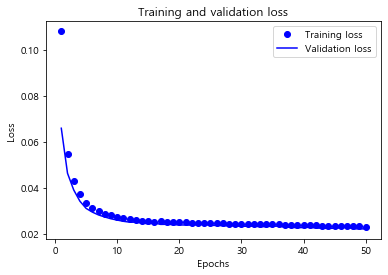

In [36]:
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')# ‘bo’는 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss')# ‘b’는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
pred = model.predict(res_test_x)

In [38]:
test_sample.columns

Index(['X303', 'X241', 'X435', 'X402', 'X352', 'X305', 'X350', 'X326', 'X299',
       'X160',
       ...
       'X266', 'X443', 'X347', 'X75', 'X107', 'X230', 'temp', 'humidity',
       'DayOfWeek', 'holiDay'],
      dtype='object', length=181)

In [39]:
## to inverse minmax scale

col_list = test_sample.columns.insert(0,'임시')
tt_index = test_sample['2018-03-03':'2018-06-30'].index

test_inverse_df = pd.DataFrame()

for i in range(1,len(test_sample.columns)-3):# feature 제외
    tmp = i*120
    tt = pred.reshape(21240  ,1)[tmp-120:tmp]    
    test_inverse_df[col_list[i]] = tt.reshape(120,)
    
test_inverse_df = test_inverse_df.set_index(tt_index)
test_inverse_df_array = sc_test.inverse_transform(test_inverse_df)

In [40]:
# inverse minmax scale DataFrame 

res_test_df = pd.DataFrame(test_inverse_df_array, columns=test_inverse_df.columns,index=tt_index)

In [41]:
# 예측한 결과물 DataFrame
# res_test_df

In [42]:
# 결과물과 원본 DataFrame 모두 inverse scaling 

In [43]:
test_none_scale = pd.read_csv('test_sample',index_col='Time',parse_dates=True)

In [44]:
test_none_scale = test_none_scale.loc[:,:'X230']['2018-03-03':'2018-06-30'].resample('D').sum()

In [45]:
test_sample.columns

Index(['X303', 'X241', 'X435', 'X402', 'X352', 'X305', 'X350', 'X326', 'X299',
       'X160',
       ...
       'X266', 'X443', 'X347', 'X75', 'X107', 'X230', 'temp', 'humidity',
       'DayOfWeek', 'holiDay'],
      dtype='object', length=181)

> 결과 체크

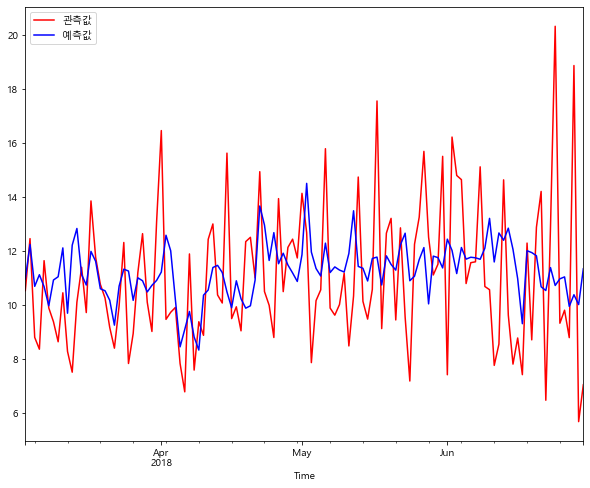

In [46]:
# 일별

test_none_scale['X303'].plot(figsize=(10,8),color='red',label='관측값')
res_test_df['X303'].plot(figsize=(10,8),color='blue',label='예측값')
plt.legend()

In [ ]:
#################### forecast#########################

In [69]:
forecast_test = pd.read_csv('forecast_test',index_col='Time',parse_dates=True)

In [71]:
from sklearn.preprocessing import MinMaxScaler

sc_test = MinMaxScaler() # testSet scaler
sc_temp = MinMaxScaler() # temp scaler
sc_humidity = MinMaxScaler()
sc_DayOfWeek = MinMaxScaler()

forecast_test_sc = sc_test.fit_transform(forecast_test.iloc[:,:-4])
temp_sc = sc_temp.fit_transform(forecast_test[['temp']])
humidity_sc = sc_humidity.fit_transform(forecast_test[['humidity']])
DayOfWeek_sc = sc_DayOfWeek.fit_transform(forecast_test[['DayOfWeek']])

forecast_test_sc = np.concatenate((forecast_test_sc, temp_sc), axis=1)
forecast_test_sc = np.concatenate((forecast_test_sc, humidity_sc), axis=1)
forecast_test_sc = np.concatenate((forecast_test_sc, DayOfWeek_sc), axis=1)

forecast_test = pd.DataFrame(forecast_test_sc, columns=forecast_test.columns[:-1],index=forecast_test.index)

forecast_test['holiDay'] = 0 # holiday feature 추가 / 우선 0으로 

for i in range(len(forecast_test)):
    if str(forecast_test.index[i])[:10] in holiday_list :
        forecast_test['holiDay'].iloc[i] = 1 # 쉬는날이면 1
    else:
        forecast_test['holiDay'].iloc[i] = 0 # 쉬는날 아니면 0

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [72]:
tmp_test_list = [] 
for i in forecast_test.columns[:-4]:
    tmp_test_list.append(forecast_test[[i,'temp','DayOfWeek','holiDay','humidity']]['2018-06-21':'2018-06-30'].values) 

to_formatted_test_x = np.array(tmp_test_list)

In [73]:
forecast_x = to_formatted_test_x

In [74]:
pred = model.predict(forecast_x)

In [ ]:
# forecast_test

In [75]:
## to inverse minmax scale

col_list = forecast_test.columns.insert(0,'임시')
tt_index = forecast_test['2018-06-01':'2018-06-10'].index # 07/01 ~ 07/10

test_inverse_df = pd.DataFrame()

for i in range(1,len(forecast_test.columns)-3):# temp col 제외
    tmp = i*10
    tt = pred.reshape(2000 ,1)[tmp-10:tmp]    
    test_inverse_df[col_list[i]] = tt.reshape(10,)
    
test_inverse_df = test_inverse_df.set_index(tt_index)
test_inverse_df_array = sc_test.inverse_transform(test_inverse_df)

In [76]:
# inverse minmax scale DataFrame 

res_forecast = pd.DataFrame(test_inverse_df_array, columns=test_inverse_df.columns,index=tt_index)

In [82]:
res_forecast.to_csv("10일 일별 예측 결과") # 07/01 24시간